# Test file

Here we test other approaches which may be promising

In [1]:
import qutip
from functions import *

## Eigenvector analysis

In [2]:
N = 5
rho_binom = qutip.ket2dm((qutip.fock(N, 0) + qutip.fock(N, 4)).unit())
noisy_rho_binom = create_states(N, [1], rho_binom, 0.1)[0]
vd_rho_binom = (noisy_rho_binom**3/(noisy_rho_binom**3).tr())

In [3]:
# find eigenvectors of this array
def print_eigen(rho, N, threshold=1e-5):
    ''' Prints eigenvalues and eigenvectors of the density matrix rho, with a threshold for the coefficients
    Returns the dominant eigenvector'''
    eigvals, eigvecs = np.linalg.eig(rho.data.toarray())
    #p = eigvals.argsort(0); inv = np.empty_like(p);   inv[p] = np.arange(p.size)
    #eigvals = eigvals[p[::-1]]
    #eigvecs = eigvecs[p[::-1]]
    #print(eigvals); print(eigvecs)
    for (i, eigval) in enumerate(eigvals):
        if eigval.real<threshold: continue
        s=""
        for j in range(N):
            coef = eigvecs[j][i]
            if abs(coef)>threshold:
                if s!="": s+= " + "
                s += f"{(coef.real if coef.imag<threshold else coef):.3f}|{j}⟩⟨{j}|"
        print(f"Probability {eigval.real:.2f}: {s}")
    return eigvecs[:,np.argmax(eigvals)]

print_eigen(noisy_rho_binom, 5)

Probability 0.84: 0.774|0⟩⟨0| + 0.633|4⟩⟨4|
Probability 0.00: -0.633|0⟩⟨0| + 0.774|4⟩⟨4|
Probability 0.00: 1.000|1⟩⟨1|
Probability 0.02: 1.000|2⟩⟨2|
Probability 0.14: 1.000|3⟩⟨3|


array([ 0.77376434+0.j, -0.        -0.j, -0.        -0.j, -0.        -0.j,
        0.63347356-0.j])

In [4]:
qutip.expect(qutip.num(N), noisy_rho_binom), qutip.expect(qutip.num(N), vd_rho_binom)

(1.809674836071919, 1.6118413779016183)

## Conclusion


# ----- Theoretical plots -----

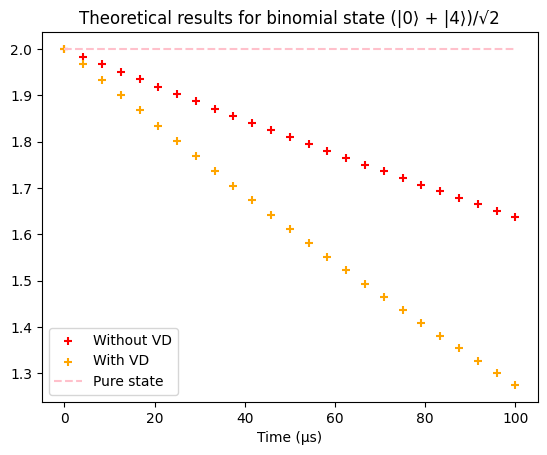

In [5]:
t_list = np.linspace(0, 100, 25)
noisy_rho_binom_list = create_states(N, t_list, rho_binom, 1/500)
vd_binom_list = [noisy_rho_binom**3/(noisy_rho_binom**3).tr() for noisy_rho_binom in noisy_rho_binom_list]

photon_number_no_vd = [qutip.expect(qutip.num(N), noisy_rho_binom) for noisy_rho_binom in noisy_rho_binom_list]
photon_number_vd = [qutip.expect(qutip.num(N), vd_rho_binom) for vd_rho_binom in vd_binom_list]

photon_number_vd_inf_th = 2*(2*np.exp(-4*0.1*t_list))/(1+np.exp(-4*0.1*t_list))
plt.scatter(t_list, photon_number_no_vd, label="Without VD", c='r', marker='+')
plt.scatter(t_list, photon_number_vd, label="With VD", c='orange', marker='+')
#plt.plot(t_list, photon_number_vd_inf_th, label="VD limit", c='b')
plt.plot(t_list, np.full_like(t_list,2), label="Pure state", c='pink', linestyle='dashed')
plt.legend()
plt.title("Theoretical results for binomial state (|0⟩ + |4⟩)/√2")
plt.xlabel("Time (μs)")
plt.show()

In [6]:
nb_points = 1000
nb_curves = 9 # modes, starts at 1
nb_n = 50 # Fock state, starts at 1
gamma_list_complete = np.linspace(0,1,nb_points)
theoretical_curves = np.zeros((nb_n, nb_curves, nb_points))
names = [["" for j in range(nb_curves)] for i in range(nb_n)]

for n_ in range(1,nb_n+1):
    theoretical_curves[n_-1][0] = n_ * np.exp(-gamma_list_complete)
    names[n_-1][0] = f"No VD, state |{n_}>"

kappa = 1/500
temporary = (np.exp(kappa * gamma_list_complete)-1)
for n_ in range(1,nb_n+1):
    for M in range(1,nb_curves):
        numerator = np.zeros_like(gamma_list_complete, dtype='O')
        denominator = np.zeros_like(gamma_list_complete, dtype='O')
        for k in range(n_+1):
            coef = (math.comb(n_, k)**M)
            numerator+=(n_-k)*coef *temporary**(M*k)
            denominator+=coef *temporary**(M*k)
        theoretical_curves[n_-1][M] = numerator/denominator
        names[n_-1][M] = f"{M+1}-mode VD, state |{n_}>"

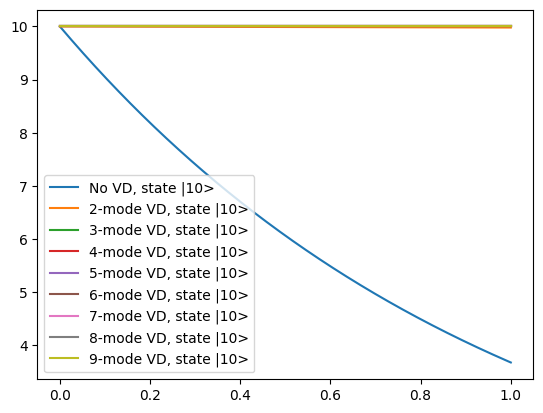

In [7]:
for i in range(9,10):
    for j in range(nb_curves):
        plt.plot(gamma_list_complete, theoretical_curves[i][j], label=names[i][j])
plt.legend()

0.10010010010010009


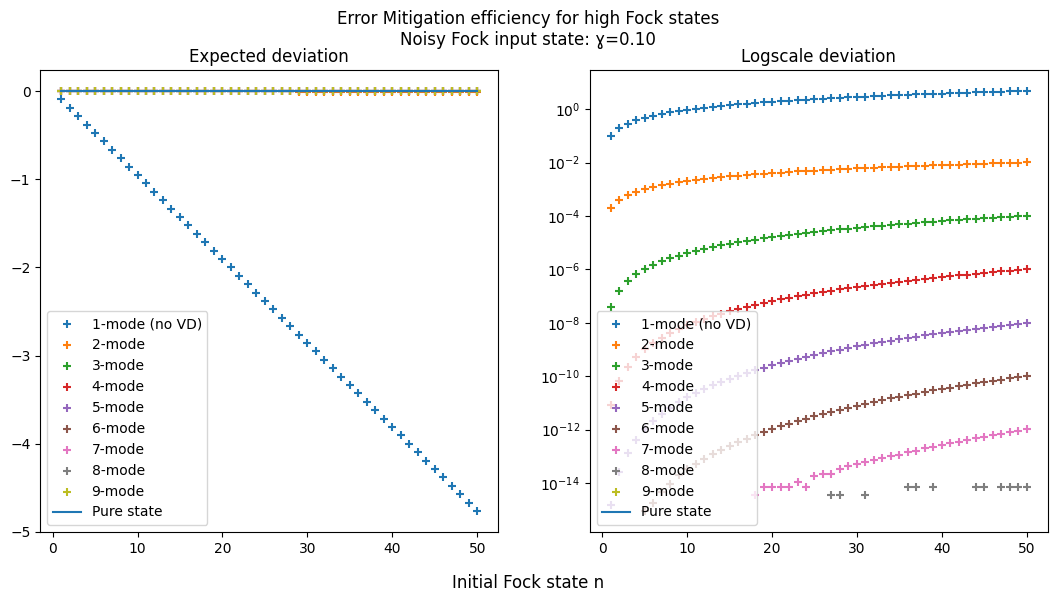

In [8]:
f, axes = plt.subplots(1, 2, figsize=(13,6))
fixed_gamma_index=100
for j in range(nb_curves):
    axes[0].scatter(np.arange(1,nb_n+1), theoretical_curves[:,j,fixed_gamma_index] -np.arange(1,nb_n+1),
                marker='+', label=f"{j+1}-mode" + (" (no VD)" if (j==0) else ""))
    axes[1].scatter(np.arange(1,nb_n+1), -theoretical_curves[:,j,fixed_gamma_index] + np.arange(1,nb_n+1),
                marker='+', label=f"{j+1}-mode" + (" (no VD)" if (j==0) else ""))
axes[0].plot(np.arange(1,nb_n+1), np.full((nb_n), 0), label="Pure state" )
axes[1].plot(np.arange(1,nb_n+1), np.full((nb_n), 0), label="Pure state" )

axes[0].legend()
axes[0].set_title("Expected deviation")
axes[1].set_yscale("log")
axes[1].legend()
axes[1].set_title("Logscale deviation")

f.supxlabel("Initial Fock state n")
f.suptitle(f"Error Mitigation efficiency for high Fock states\nNoisy Fock input state: ɣ={gamma_list_complete[fixed_gamma_index]:.2f}")

print(gamma_list_complete[fixed_gamma_index])

On the right plot we see pretty clearly the exponential scaling of the correction as the number of modes increases. In fact, the spacing is the same between each curve, because we are looking at $\log(p^M)=M*\log p$ for different values of M.

We also see that the deviation seems to stabilize, but looking at the left plot it rather seems that it grows linearly with $n$.

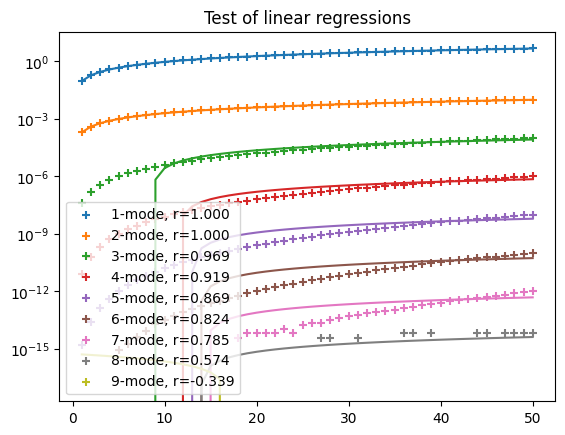

In [9]:
import scipy.stats as sts
x = np.arange(1, nb_n+1)
for j in range(nb_curves):
    a = x-theoretical_curves[:,j,fixed_gamma_index]
    slope, intercept, r, p, se = sts.linregress(x, a)
    plt.scatter(x, a, marker='+', label=f"{j+1}-mode, r={r:.3f}")
    plt.plot(x, slope*x+intercept)
plt.yscale("log")
plt.title("Test of linear regressions")
plt.legend()

Ok for few modes but as soon as we go further it’s not that clear

Now let’s try plotting as a function of number of modes.

## ----- Plots for report and tests ------

Text(0, 0.5, 'Coefficient')

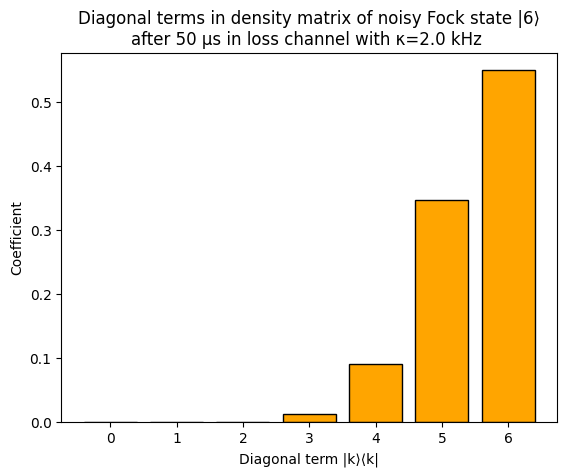

In [10]:
N=10
n=6
t=50
rho = create_states(N, [t], qutip.fock_dm(N,n), kappa, 1)[0]
plt.bar(np.arange(n+1),np.abs(np.diag(rho))[:n+1], color='orange', linestyle='-', edgecolor='black')
plt.title(f"Diagonal terms in density matrix of noisy Fock state |{n}⟩\nafter {t} μs in loss channel with κ={1000*kappa} kHz ")
plt.xlabel("Diagonal term |k⟩⟨k|")
plt.ylabel("Coefficient")

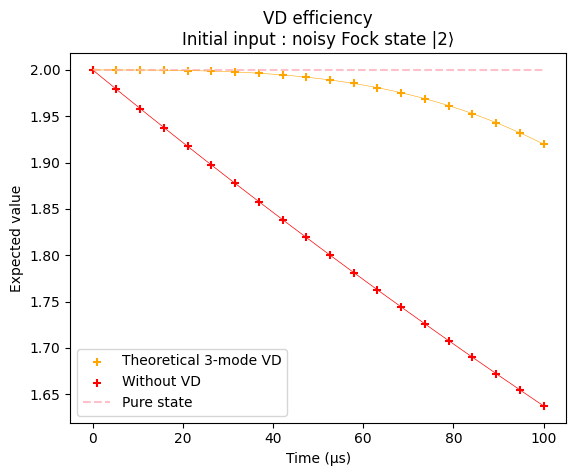

In [11]:
# same t_list as the beginning
import qutip
from functions import *
t_max = 100
N=5
n=2
nb_samples = 20
T_1=500 # μs
kappa = 1/T_1
t_list = np.linspace(0,t_max,nb_samples)
rho_list = create_states(N, t_list, rho_0 = qutip.fock_dm(N,n), kappa=kappa)

r, r_loss, r_th = perform_protocol(N, rho_list, [], [1,3], False, None)
r_th_1, r_th_3 = r_th
plot_all(t_list, r, r_loss, [(r_th_3, "Theoretical 3-mode VD"), (r_th_1, "Without VD"),],
         title="Fock state |2⟩", kappa=kappa, gamma_loss=None, show_only_th=True, show_curves=n)

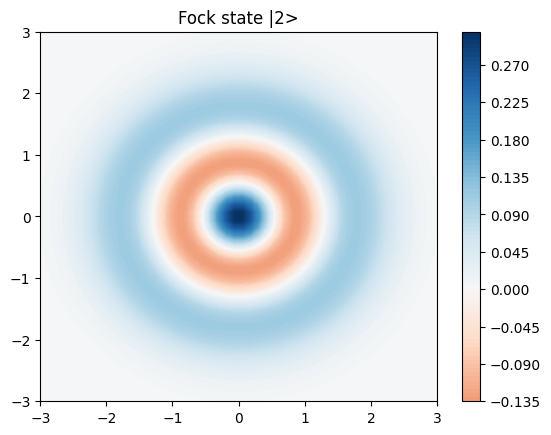

In [12]:
bound = 3
xvec, yvec = np.linspace(-bound,bound,50), np.linspace(-bound,bound,50)
plot_wigner(qutip.fock_dm(N,2), xvec, yvec, plt.figure(), plt.gca(), 'RdBu', "Fock state |2>", density=True)

GKP

<BarContainer object of 21 artists>

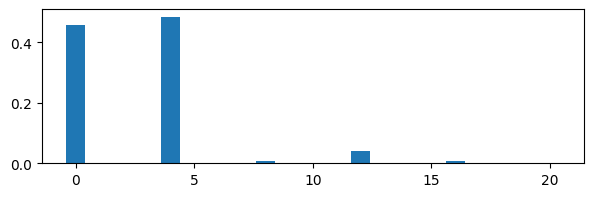

In [13]:
N = 21
psi_gkp = gkp_state(0.4, N)
rho_gkp = qutip.ket2dm(psi_gkp)
plt.figure(figsize=(7,2))
plt.bar(np.arange(N), np.abs(np.diag(rho_gkp)))

<BarContainer object of 21 artists>

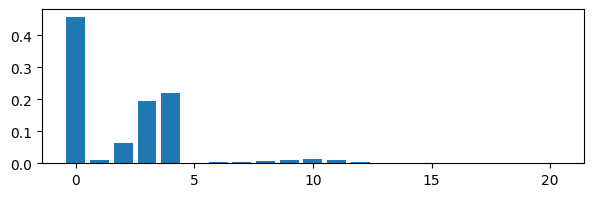

In [14]:
gamma_list = np.linspace(0,0.2,4)
noisy_gkp_list = create_states(N, gamma_list, rho_gkp, 1)
plt.figure(figsize=(7,2))
plt.bar(np.arange(N), np.abs(np.diag(noisy_gkp_list[3])))

In [15]:
dom_eigen = print_eigen(noisy_gkp_list[3], N, threshold=1e-3)

Probability 0.68: 0.820|0⟩⟨0| + -0.005|2⟩⟨2| + 0.566|4⟩⟨4| + 0.021|6⟩⟨6| + -0.042|8⟩⟨8| + -0.005|10⟩⟨10| + 0.074|12⟩⟨12| + 0.004|14⟩⟨14| + 0.020|16⟩⟨16| + 0.005|18⟩⟨18| + -0.005|20⟩⟨20|
Probability 0.08: -0.020|0⟩⟨0| + 0.896|2⟩⟨2| + 0.040|4⟩⟨4| + -0.147|6⟩⟨6| + -0.022|8⟩⟨8| + 0.386|10⟩⟨10| + 0.020|12⟩⟨12| + 0.143|14⟩⟨14| + 0.042|16⟩⟨16| + -0.048|18⟩⟨18|
Probability 0.21: -0.005|1⟩⟨1| + 0.967|3⟩⟨3| + 0.043|5⟩⟨5| + -0.105|7⟩⟨7| + -0.013|9⟩⟨9| + 0.217|11⟩⟨11| + 0.011|13⟩⟨13| + 0.070|15⟩⟨15| + 0.019|17⟩⟨17| + -0.020|19⟩⟨19|
Probability 0.01: 0.181|0⟩⟨0| + -0.008|2⟩⟨2| + -0.250|4⟩⟨4| + -0.030|6⟩⟨6| + 0.819|8⟩⟨8| + 0.038|10⟩⟨10| + 0.420|12⟩⟨12| + 0.137|14⟩⟨14| + -0.190|16⟩⟨16| + 0.002|18⟩⟨18|
Probability 0.02: 0.669|1⟩⟨1| + 0.004|3⟩⟨3| + -0.191|5⟩⟨5| + -0.027|7⟩⟨7| + 0.645|9⟩⟨9| + 0.030|11⟩⟨11| + 0.283|13⟩⟨13| + 0.086|15⟩⟨15| + -0.108|17⟩⟨17| + 0.001|19⟩⟨19|
Probability 0.00: -0.037|1⟩⟨1| + -0.019|3⟩⟨3| + -0.011|5⟩⟨5| + 0.786|7⟩⟨7| + 0.006|9⟩⟨9| + 0.536|11⟩⟨11| + 0.167|13⟩⟨13| + -0.255|15⟩⟨1

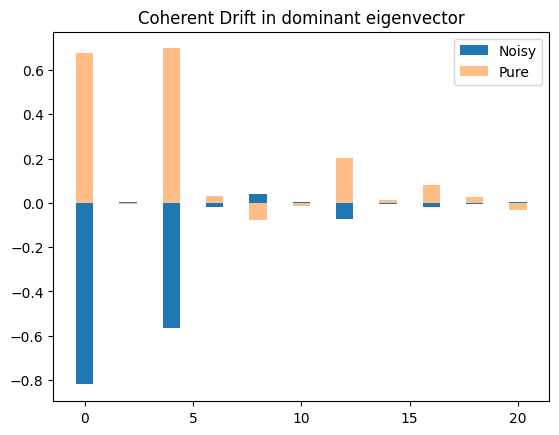

In [16]:
plt.bar(np.arange(N), -np.real(dom_eigen), label="Noisy")
plt.bar(np.arange(N), np.real(psi_gkp.full().flatten()), alpha=0.5, label="Pure")
plt.title("Coherent Drift in dominant eigenvector")
plt.legend()